In [1]:
from tracr.rasp import rasp

def make_sort_unique(vals: rasp.SOp, keys: rasp.SOp) -> rasp.SOp:
  """Returns vals sorted by < relation on keys.

  Only supports unique keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
  """
  smaller = rasp.Select(keys, keys, rasp.Comparison.LT).named("smaller")
  target_pos = rasp.SelectorWidth(smaller).named("target_pos")
  sel_new = rasp.Select(target_pos, rasp.indices, rasp.Comparison.EQ)
  return rasp.Aggregate(sel_new, vals).named("sort")


def make_sort(vals: rasp.SOp, keys: rasp.SOp, *, max_seq_len: int,
              min_key: float) -> rasp.SOp:
  """Returns vals sorted by < relation on keys, which don't need to be unique.

  The implementation differs from the RASP paper, as it avoids using
  compositions of selectors to break ties. Instead, it uses the arguments
  max_seq_len and min_key to ensure the keys are unique.

  Note that this approach only works for numerical keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens, 5, 1)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]
    sort([2, 4, 1, 2])
    >> [1, 2, 2, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
    max_seq_len: Maximum sequence length (used to ensure keys are unique)
    min_key: Minimum key value (used to ensure keys are unique)

  Returns:
    Output SOp of sort program.
  """
  keys = rasp.SequenceMap(lambda x, i: x + min_key * i / max_seq_len, keys,
                          rasp.indices)
  return make_sort_unique(vals, keys)


In [2]:
from tracr.compiler import compiling

sort = make_sort(rasp.tokens, rasp.tokens, max_seq_len=20, min_key=1)
bos = "BOS"
max_seq_len=5
model = compiling.compile_rasp_to_model(
    sort,
    vocab={0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
    max_seq_len=max_seq_len,
    compiler_bos=bos,
)
print(model.model_config)

TransformerConfig(num_heads=1, num_layers=3, key_size=52, mlp_hidden_size=50, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x71e8583b76b0>, layer_norm=False, causal=False)


In [3]:
import numpy as np
import jax

acceptedTokens = list(range(1, 10))
maxSeqLength = max_seq_len
size = 10000
X = []
Y = []

for i in range(size):
    # TODO: implement padding for training
    # inputLength = np.random.randint(2, maxSeqLength+1)  #Uniformly distributed between 2 and max length
    inputLength = maxSeqLength

    inputSeq = []
    outputSeq = []
    for t in np.random.choice(acceptedTokens, inputLength):
        inputSeq.append(t)
        outputSeq.append(t)

    inputSeq.insert(0, bos)
    outputSeq.sort()
    outputSeq.insert(0, 0) # The output_encoder does has a None bos_encoding, so we use the input_encoder's

    inputSeq = jax.numpy.array(model.input_encoder.encode(inputSeq))
    outputSeq = jax.numpy.array(model.output_encoder.encode(outputSeq))

    X.append(inputSeq)
    Y.append(outputSeq)

X = jax.numpy.array(X)
Y = jax.numpy.array(Y)

X, Y
print(X.shape)

# Remove duplicates from X, and the corresponding Y
X, indices = np.unique(X, return_index=True, axis=0)
Y = Y[indices]
print(X.shape)

# Split test and validation
split = int(X.shape[0] * 0.99)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]
print(X_train.shape, X_test.shape)

(10000, 6)
(9245, 6)
(9152, 6) (93, 6)


In [4]:
import haiku as hk
import jax

params = model.params

hk_model = hk.transform(model.get_compiled_model)
hk_model = hk_model.apply(params, jax.random.PRNGKey(42))
hk_model.use_unembed_argmax = False

In [5]:
def forward(x):
    return hk_model(x)

forward = hk.transform(forward)

In [6]:
output = forward.apply(model.params, jax.random.PRNGKey(42), jax.numpy.array([[10, 4, 5, 2, 6, 3]]))
print(output.unembedded_output)
print(output.unembedded_output.argmax(axis=-1))

[[[0.0000000e+00 0.0000000e+00 9.6961419e-04 9.6961419e-04 9.6961419e-04
   9.6961419e-04 9.6961419e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 9.9902284e-01 9.4840647e-07 9.4840647e-07
   9.4840647e-07 9.4840647e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 9.4840647e-07 9.9902284e-01 9.4840647e-07
   9.4840647e-07 9.4840647e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 9.4840647e-07 9.4840647e-07 9.9902284e-01
   9.4840647e-07 9.4840647e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 9.4840647e-07 9.4840647e-07 9.4840647e-07
   9.9902284e-01 9.4840647e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 9.4840823e-07 9.4843352e-07 9.4840823e-07
   9.4840823e-07 9.9902284e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00]]]
[[2 2 3 4 5 6]]


In [7]:
model.apply([bos, 4, 5, 2, 6, 3]).decoded

['BOS', 2, 3, 4, 5, 6]

In [8]:
import haiku as hk
import jax
import jax.numpy as jnp

jax.config.update('jax_default_matmul_precision', 'float32')
jax.config.update("jax_enable_x64", True)


@jax.jit
def cross_entropy(logits, labels):
  return -jnp.sum(labels * jax.nn.log_softmax(logits)) / logits.shape[0]

# TODO: ignore first position
@jax.jit
def loss_fn(params, x, y):
  logits = forward.apply(params, jax.random.PRNGKey(42), x).unembedded_output
  labels = jax.nn.one_hot(y, logits.shape[-1])
  return cross_entropy(logits, labels)

@jax.jit
def update(params, x, y, lr=0.0001):
  grads = jax.grad(loss_fn)(params, x, y)
  return jax.tree_util.tree_map(
      lambda p, g: p - lr * g, model.params, grads
  )

In [9]:
import tqdm
import matplotlib.pyplot as plt

def train(params, X, Y, n_epochs=1, batch_size=8, lr=0.0001, plot=False):
    losses = []  # to store the loss values

    for _ in tqdm.trange(n_epochs):
        for i in range(0, len(X), batch_size):
            x = X[i:i + batch_size]
            y = Y[i:i + batch_size]
            params = update(params, x, y, lr)
            
        # Compute loss every epoch
        if plot:
            loss = loss_fn(params, X, Y)
            losses.append(loss)

    if plot:
        # plot the loss values
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

    return params

In [10]:
def evaluate(params, X, Y):
    """
    Computes the accuracy (exact-match) of the model on the given data (X) and labels (Y).
    """
    correct = 0
    for x, y in zip(X, Y):
        logits = forward.apply(params, jax.random.PRNGKey(42), jax.numpy.array([x])).unembedded_output
        pred = jnp.argmax(logits, axis=-1)[0]
        correct += jnp.all(pred[1:] == y[1:])
    return correct / len(X)

In [11]:
evaluate(model.params, X_test, Y_test)

Array(1., dtype=float64, weak_type=True)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


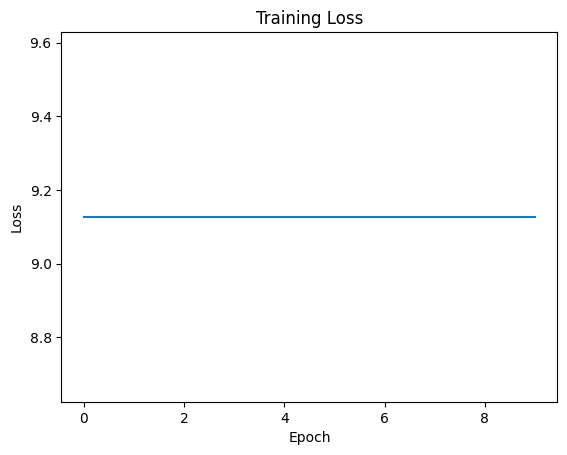

In [12]:
new_params = train(model.params, X_train, Y_train, n_epochs=10, batch_size=128, lr=1e-5, plot=True)

In [13]:
print(X_test[0])
print(Y_test[0])

print(forward.apply(new_params, jax.random.PRNGKey(42), jax.numpy.array([X_test[0]])).unembedded_output.argmax(axis=-1))

[10  9  9  2  4  2]
[0 2 2 4 9 9]
[[0 2 2 4 9 9]]


In [14]:
evaluate(new_params, X_test, Y_test)

Array(1., dtype=float64, weak_type=True)

In [15]:
def initialize_normal(params, mean=0.0, std=1.0):
    return jax.tree_util.tree_map(
        lambda p: jax.random.normal(jax.random.PRNGKey(42), p.shape) * std + mean,
        params
    )

random_params = initialize_normal(model.params)

In [16]:
evaluate(random_params, X_test, Y_test)

Array(0., dtype=float64, weak_type=True)

In [17]:
print(X_test[0])
print(Y_test[0])

print(forward.apply(random_params, jax.random.PRNGKey(42), jax.numpy.array([X_test[0]])).unembedded_output.argmax(axis=-1))

[10  9  9  2  4  2]
[0 2 2 4 9 9]
[[5 7 6 7 5 7]]


In [18]:
import pandas as pd

# Define the hyper-parameter values to search
n_epochs_values = [1]
batch_size_values = [128]
learning_rate_values = [1e-3]

# Create an empty DataFrame to store the results
results = []

# Perform hyper-parameter search
for n_epochs in n_epochs_values:
    for batch_size in batch_size_values:
        for learning_rate in learning_rate_values:
            # Train the model with the current hyper-parameters
            trained_params = train(random_params, X_train, Y_train, n_epochs=n_epochs, batch_size=batch_size, lr=learning_rate)
            
            # Evaluate the model on the test set
            accuracy = evaluate(trained_params, X_test, Y_test)
            
            # Append the results to the DataFrame
            results.append({"n_epochs": n_epochs, "batch_size": batch_size, "learning_rate": learning_rate, "accuracy": accuracy})

# Print the results
print(pd.DataFrame(results).to_string())

100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


   n_epochs  batch_size  learning_rate accuracy
0         1         128          0.001      0.0


In [19]:
trained_params

{'pos_embed': {'embeddings': Array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, na